In [1]:
import tqdm
import pickle
import pyreadr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Patch

import rasterio
from rasterio.transform import Affine
from rasterio.windows import from_bounds

from eval_utils import fast_auc

np.random.seed(1234)

In [2]:
map_path = "/hpc/group/dunsonlab/szw3/finland/data/location_maps/"
spnames = ["actitis_hypoleucos", "spinus_spinus", "turdus_merula", "turdus_pilaris"]
p = len(spnames)

In [3]:
min_lon, max_lon = 21, 30
min_lat, max_lat = 59.7, 62.7

for j in tqdm.tqdm(range(p)):
    sp = spnames[j]

    with rasterio.open(map_path + sp + "_a.tif") as src:
        window = from_bounds(min_lon, min_lat, max_lon, max_lat, transform=src.transform)
        a_j_prior = src.read(1, window=window)
        transform = src.window_transform(window)
        profile = src.profile.copy()
        profile.update({"height": a_j_prior.shape[0], "width": a_j_prior.shape[1], "transform": transform})
        height, width = a_j_prior.shape[0], a_j_prior.shape[1]
    with rasterio.open(map_path + sp + "_a_app2023.tif") as src:
        window = from_bounds(min_lon, min_lat, max_lon, max_lat, transform=src.transform)
        a_j_post = src.read(1, window=window)

    if j==0:
        a_prior = np.zeros([height, width, p])
        a_post = np.zeros([height, width, p])

    a_prior[:,:,j] = a_j_prior
    a_post[:,:,j] = a_j_post
    
ys = np.arange(height)
_, lat_grid = rasterio.transform.xy(transform, ys, np.zeros_like(ys))
lat_grid = np.array(lat_grid)
xs = np.arange(width)
lon_grid, _ = rasterio.transform.xy(transform, np.zeros_like(xs), xs)
lon_grid = np.array(lon_grid)
lat2d, lon2d = np.meshgrid(lat_grid, lon_grid, indexing='ij')

100%|██████████| 4/4 [00:06<00:00,  1.52s/it]


In [4]:
n_sci = 20
coords_sci = []
idx_sci = []
in_bounds = ~np.isnan(a_prior).all(axis=2)

while len(coords_sci) < n_sci:
    lon = np.random.uniform(lon_grid[0], lon_grid[-1])
    lat = np.random.uniform(lat_grid[-1], lat_grid[0])
    row, col = rasterio.transform.rowcol(transform, lon, lat)
    if in_bounds[row, col]:
        coords_sci.append([lon, lat])
        idx_sci.append([row, col])

In [5]:
def make_mask(R_cells):
    y, x = np.ogrid[-R_cells:R_cells+1, -R_cells:R_cells+1]
    mask = (x**2 + y**2) <= R_cells**2
    return mask

def apply_mask(target, row, col, mask, invert=False):
    out = target.copy()
    H, W = target.shape
    k = mask.shape[0]
    R = k // 2
    r0 = max(0, row - R)
    r1 = min(H, row + R + 1)
    c0 = max(0, col - R)
    c1 = min(W, col + R + 1)
    mr0 = R - (row - r0)
    mr1 = mr0 + (r1 - r0)
    mc0 = R - (col - c0)
    mc1 = mc0 + (c1 - c0)
    m = mask[mr0:mr1, mc0:mc1]
    if invert:
        out[r0:r1, c0:c1][m] = 0
    else:
        out[:] = 0
        out[r0:r1, c0:c1][m] = target[r0:r1, c0:c1][m]
    return out

r_search = 50
search_circle = make_mask(10*r_search)
sci_mask = np.ones([height, width, n_sci]).astype(bool)
for i in tqdm.tqdm(range(n_sci)):
    sci_mask[:,:,i] = apply_mask(sci_mask[:,:,i], idx_sci[i][0], idx_sci[i][1], search_circle)
sci_mask = sci_mask*in_bounds[:, :, None]
search_map = np.any(sci_mask, axis=2)

100%|██████████| 20/20 [00:01<00:00, 10.46it/s]


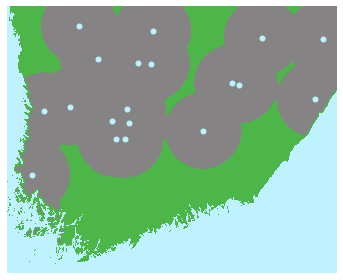

In [6]:
cmap_base = ListedColormap(['#BEF2FF', '#4CB648'])
circle_cmap = ListedColormap(['#858383'])

fig, ax = plt.subplots()
im = ax.imshow(in_bounds, cmap=cmap_base, origin='upper')
alpha_mask = np.ma.masked_where(~search_map, search_map)
ax.imshow(alpha_mask, cmap=circle_cmap, alpha=1, origin='upper')

lons = np.array(coords_sci)[:,0]
lats = np.array(coords_sci)[:,1]
y, x = rasterio.transform.rowcol(transform, lons, lats)
ax.plot(x, y, 'o', color='#BEF2FF', markersize=5)

plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
sites_per_day = 10
r_day = 10
r_min = 1 # change to 0.5

day_circle = make_mask(10*r_day)
site_circle = make_mask(10*r_min)

In [8]:
Us = []
sci_id = []
locations = []
idx = []
global_mask = in_bounds.copy() # prevents searching near previously searched sites

tau = 400 # sigma = 1/sqrt(tau)
gamma = 0.95
delta = np.abs(a_post - a_prior)

res = 0.01
grid_vals = np.arange(0, 1 + res, res) 
grid_max_idx = len(grid_vals) - 1
log_kernel_grid = np.zeros((len(grid_vals), len(grid_vals), p))
M = n_sci*sites_per_day

repulsion_grids = []
repulsion_maps = []

T = 8
for t in range(T):    
    if t==0:
        U_active = np.sum(delta, axis=2)
    else:
        idx_arr = np.array(idx).reshape(t*n_sci*sites_per_day, 2)
        prior_sel = a_prior[idx_arr[:,0], idx_arr[:,1], :]
        post_sel = a_post[idx_arr[:,0], idx_arr[:,1], :]
        prior_new = prior_sel[-M:,:]
        post_new  = post_sel[-M:,:]

        d2_prior = np.square(grid_vals[:, None, None] - prior_new[None, :, :])
        d2_post  = np.square(grid_vals[:, None, None] - post_new[None, :, :])
        d2 = d2_prior[:, None, :, :] + d2_post[None, :, :, :]
        log_kernel = np.log(1 - gamma*np.exp(-0.5*tau*d2))
        log_kernel_grid += np.sum(log_kernel, axis=2)
        
        grid_idx_prior = np.clip(np.round(a_prior / res).astype(int), 0, grid_max_idx)
        grid_idx_post  = np.clip(np.round(a_post / res).astype(int), 0, grid_max_idx)
        log_repulsion = np.empty_like(a_prior, dtype=np.float32)
        for j in range(p):
            log_repulsion[:, :, j] = log_kernel_grid[grid_idx_prior[:, :, j], grid_idx_post[:, :, j], j]
        
        repulsion = np.exp(log_repulsion)
        repulsion = np.where(in_bounds[:,:, None], repulsion, np.nan)
        U_active = np.sum(delta*repulsion, axis=2)
        repulsion_grids.append(np.exp(log_kernel_grid))
        repulsion_maps.append(repulsion)

    sci_id.append([])
    locations.append([])
    idx.append([])
    # should permute this order across days, np.shuffle
    for i in tqdm.tqdm(range(n_sci), desc="Day "+str(t+1)+"/"+str(T)):
        sci_id[-1].append(i)
        loc_i, idx_i = [], []

        # Get the first study location for scientist i
        local_mask = sci_mask[:,:,i].copy()
        U_local = U_active*local_mask*global_mask
        coords = np.where(U_local == np.nanmax(U_local))
        row, col = coords[0][0], coords[1][0]
        loc_i.append((lat_grid[row], lon_grid[col]))
        idx_i.append([row, col])

        # exclude cells further than r_day away
        local_mask = apply_mask(sci_mask[:,:,i], idx_i[0][0], idx_i[0][1], day_circle)
        
        # search for additional cells in a neighborhood
        while len(loc_i) < sites_per_day:
            global_mask = apply_mask(global_mask, idx_i[-1][0], idx_i[-1][1], site_circle, invert=True)
            U_local = U_active*local_mask*global_mask
            coords = np.where(U_local == np.nanmax(U_local))
            row, col = coords[0][0], coords[1][0]
            loc_i.append((lat_grid[row], lon_grid[col]))
            idx_i.append([row, col])

        locations[-1].append(loc_i)
        idx[-1].append(idx_i)

Day 1/8: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]
<ipython-input-8-456938874fc4>:38: RuntimeWarning: invalid value encountered in cast
  grid_idx_prior = np.clip(np.round(a_prior / res).astype(int), 0, grid_max_idx)
<ipython-input-8-456938874fc4>:39: RuntimeWarning: invalid value encountered in cast
  grid_idx_post  = np.clip(np.round(a_post / res).astype(int), 0, grid_max_idx)
Day 8/8: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


In [9]:
def collect_results(locations, idx, sci_id):
    records = []
    T = len(locations)
    for t in range(T):
        for i in range(len(locations[t])):
            sid = sci_id[t][i]
            for j, (latlon, rc) in enumerate(zip(locations[t][i], idx[t][i])):
                lat, lon = latlon
                row, col = rc
                records.append((t, sid, j, lat, lon, row, col))
    return pd.DataFrame(records, columns=["t", "sci_id", "exp_id", "lat", "lon", "row", "col"])

res = collect_results(locations, idx, sci_id)
prior_sel = pd.DataFrame(a_prior[res["row"], res["col"],:], columns=spnames)
post_sel = pd.DataFrame(a_post[res["row"], res["col"],:], columns=spnames)
res.head()

,t,sci_id,exp_id,lat,lon,row,col
0,0,0,0,61.625427,23.217255,1211,1030
1,0,0,1,61.615670,23.210800,1222,1027
2,0,0,2,61.628088,23.243074,1208,1042
3,0,0,3,61.569547,23.326988,1274,1081
4,0,0,4,61.632523,23.178525,1203,1012


In [10]:
diff = a_prior - a_post
G1, G2 = np.meshgrid(grid_vals, grid_vals, indexing='ij')
delta_grid = np.abs(G1 - G2)
repulsion_grids.insert(0, np.ones_like(repulsion_grids[0]))
repulsion_maps.insert(0, np.ones_like(repulsion_maps[0]))

100%|██████████| 8/8 [00:35<00:00,  4.40s/it]
<ipython-input-26-6ee52a52ab63>:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


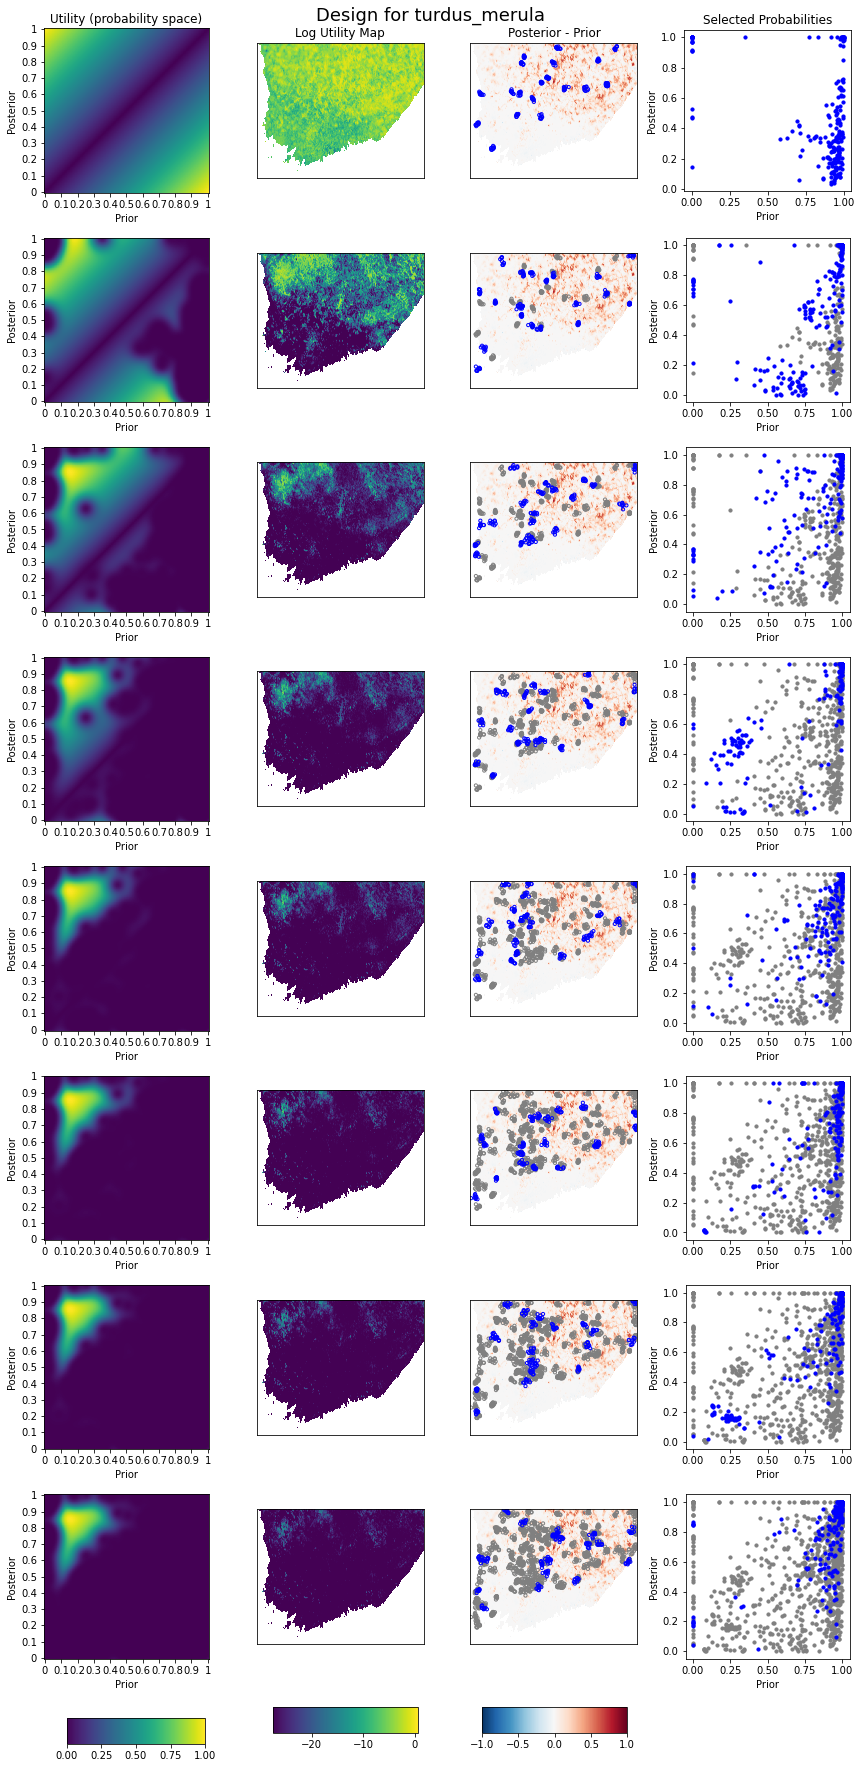

In [26]:
j = 2

fig, axs = plt.subplots(T, 4, figsize=(12, 3*T))
for ax_row in axs:
    for ax in ax_row:
        ax.set_aspect('equal')
        
im_handles = [None, None, None]
vmin1 = np.nanmin([np.nanmin(np.log(delta[:, :, j] * repulsion_maps[t][:, :, j] + 1e-12)) for t in range(T)])
        
for t in tqdm.tqdm(range(T)):
    U = delta_grid*repulsion_grids[t][:, :, j]
    im0 = axs[t, 0].imshow(U.T, origin="lower")
    tick_locs = np.linspace(0, 100, 11).astype(int)
    tick_labels = [f"{v/100:.1g}" for v in tick_locs]
    axs[t, 0].set_xticks(tick_locs)
    axs[t, 0].set_xticklabels(tick_labels)
    axs[t, 0].set_yticks(tick_locs)
    axs[t, 0].set_yticklabels(tick_labels)

    im1 = axs[t, 1].imshow(np.log(delta[:, :, j] * repulsion_maps[t][:, :, j] + 1e-12), origin="upper", vmin = vmin1, vmax=np.log(2))

    im2 = axs[t, 2].imshow(diff[:, :, j], vmin=-1, vmax=1, cmap="RdBu_r", origin="upper")
    axs[t, 2].scatter(res.col[:M * t], res.row[:M * t], facecolors='none', edgecolors='grey', s=10)
    axs[t, 2].scatter(res.col[M * t:M * (t + 1)], res.row[M * t:M * (t + 1)], facecolors='none', edgecolors='blue', s=10)

    axs[t, 3].scatter(prior_sel.loc[:M * t, spnames[j]], post_sel.loc[:M * t, spnames[j]], color="grey", s=10)
    axs[t, 3].scatter(prior_sel.loc[M * t:M * (t + 1), spnames[j]], post_sel.loc[M * t:M * (t + 1), spnames[j]], color="blue", s=10)

    for k in [1, 2]:
        axs[t, k].set_xticks([])
        axs[t, k].set_yticks([])

    axs[t, 0].set_xlabel("Prior")
    axs[t, 3].set_xlabel("Prior")
    axs[t, 0].set_ylabel("Posterior")
    axs[t, 3].set_ylabel("Posterior")

    if t == 0:
        axs[0, 0].set_title("Utility (probability space)")
        axs[0, 1].set_title("Log Utility Map")
        axs[0, 2].set_title("Posterior - Prior")
        axs[0, 3].set_title("Selected Probabilities")
        im_handles[0] = im0
        im_handles[1] = im1
        im_handles[2] = im2
        
    fig.canvas.draw()
        
xd = [0.05, 0.01, -0.03]
for col, im in enumerate(im_handles):
    ax = axs[-1, col] 
    box = ax.get_position()
    cax = fig.add_axes([
        box.x0 - xd[col],
        box.y0 - 0.15,
        box.width,
        0.015
    ])
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")

plt.suptitle("Design for " + spnames[j], fontsize=18)
plt.tight_layout()
plt.show()

# Add in better error handling if no valid sites

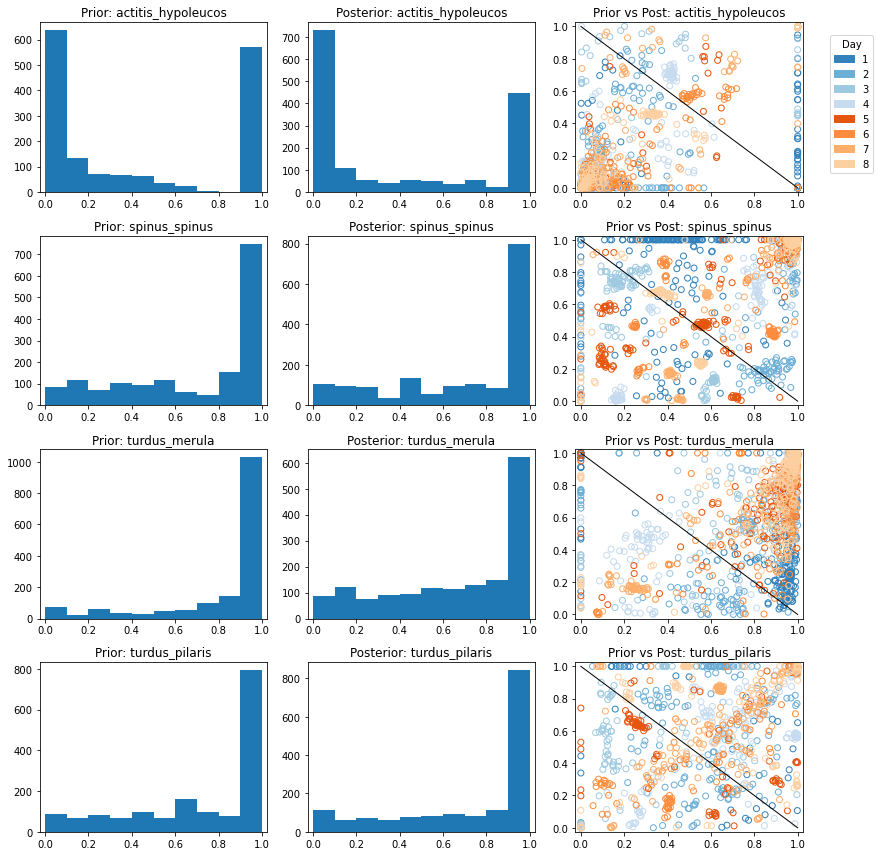

In [23]:
fig, axs = plt.subplots(p, 3, figsize=(12, 3 * p))  # p rows, 3 columns
cmap = plt.cm.tab20c
colors = [cmap(i % cmap.N) for i in range(T)]

for j in range(p):
    axs[j, 0].hist(prior_sel[spnames[j]])
    axs[j, 0].set_title(f"Prior: {spnames[j]}")
    axs[j, 0].set_xlim(-0.025, 1.025)

    axs[j, 1].hist(post_sel[spnames[j]])
    axs[j, 1].set_title(f"Posterior: {spnames[j]}")
    axs[j, 1].set_xlim(-0.025, 1.025)

    for t_val in range(T):
        mask = res["t"] == t_val
        axs[j, 2].scatter(prior_sel.loc[mask, spnames[j]],
                          post_sel.loc[mask, spnames[j]],
                          color=colors[t_val], facecolors="none")
    axs[j, 2].plot([0, 1], [1, 0], color="black", linewidth=1)
    axs[j, 2].set_xlim(-0.025, 1.025)
    axs[j, 2].set_ylim(-0.025, 1.025)
    axs[j, 2].set_title(f"Prior vs Post: {spnames[j]}")

legend_handles = [Patch(color=colors[t], label=f"{t+1}") for t in range(T)]
fig.legend(handles=legend_handles, title="Day", loc='upper right', bbox_to_anchor=(1.02, 0.96))

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


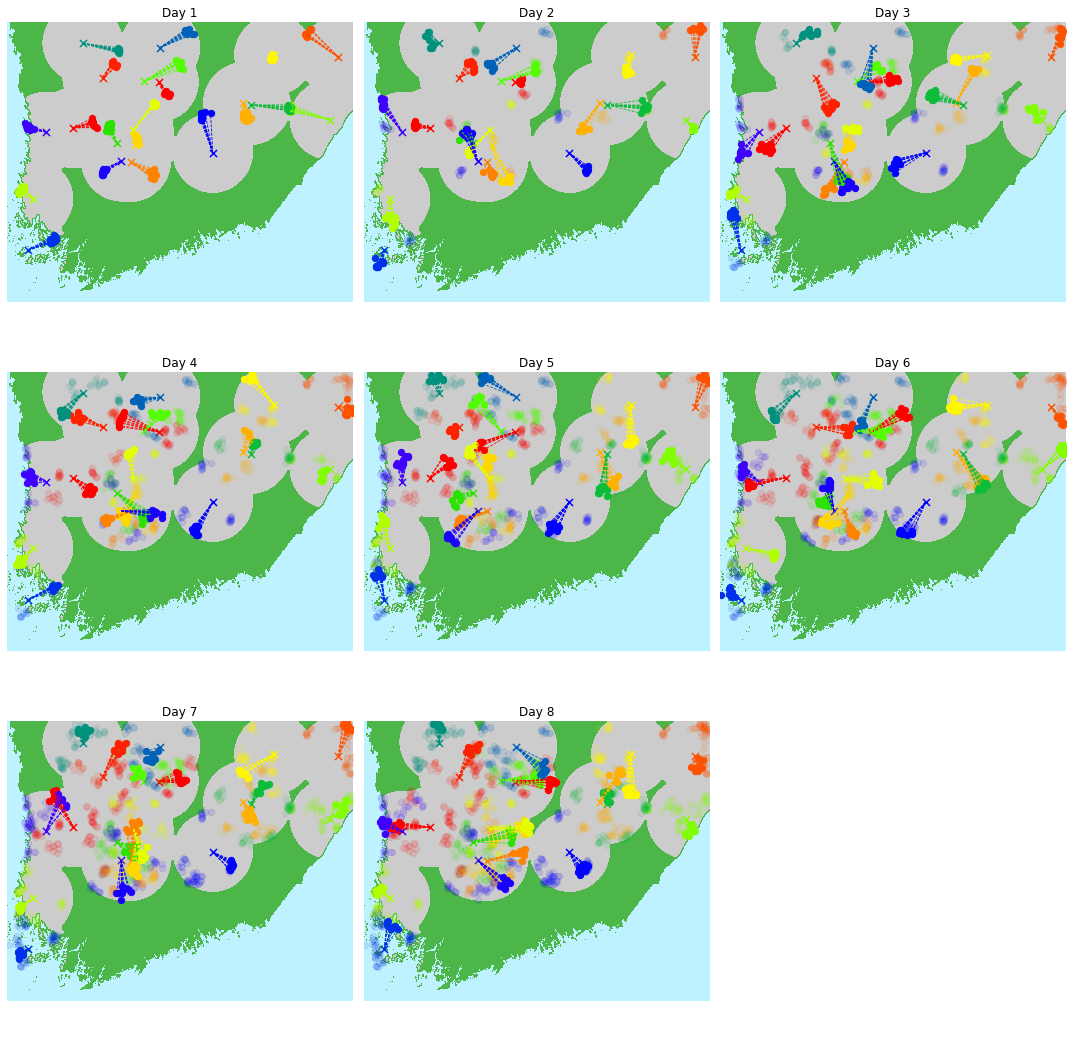

In [14]:
cmap_base = ListedColormap(['#BEF2FF', '#4CB648'])
circle_cmap = ListedColormap(['#cccccc'])

n_cols = 3
n_rows = (T + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
axes = axes.flatten()

for t in tqdm.tqdm(range(T)):
    ax = axes[t] if T > 1 else axes
    ax.imshow(in_bounds, cmap=cmap_base, origin='upper')
    alpha_mask = np.ma.masked_where(~search_map, search_map)
    ax.imshow(alpha_mask, cmap=circle_cmap, alpha=1, origin='upper')

    for i in range(n_sci):
        center = coords_sci[i]
        y, x = rasterio.transform.rowcol(transform, center[0], center[1])
        color = plt.cm.prism(i)
        ax.scatter(x, y, color=color, marker='x', s=50)

    for t_prev in range(t + 1):
        alpha_val = 0.1 if t_prev < t else 1.0
        for i, sid in enumerate(sci_id[t_prev]):
            center = coords_sci[sid]
            y, x = rasterio.transform.rowcol(transform, center[0], center[1])
            color = plt.cm.prism(i)        

            neighbors = np.array(idx[t_prev][i])
            ax.scatter(neighbors[:, 1], neighbors[:, 0], facecolor=color, edgecolors=color, s=40, alpha=alpha_val)
            if alpha_val>0.5:
                for point in neighbors:
                    ax.plot([x, point[1]], [y, point[0]], color=color, linewidth=0.8, linestyle="dashed", alpha=alpha_val)

    ax.set_title(f"Day {t+1}")
    ax.axis('off')
    
for t in range(T, len(axes)):
    axes[t].axis('off')

plt.tight_layout()
plt.show()

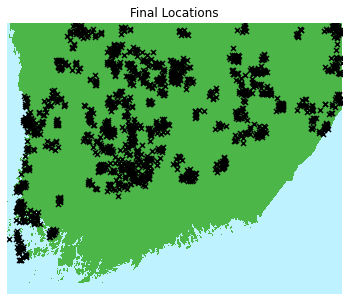

In [15]:
plt.figure(figsize=(6,7))
plt.imshow(in_bounds, cmap=cmap_base, origin='upper')
plt.scatter(res["col"], res["row"], marker='x', s=25, color="black");
plt.axis('off')
plt.title("Final Locations");

In [16]:
AUCs = {}
m = 5
n = post_sel.shape[0]

for j in range(p):
    p_prior = prior_sel[spnames[j]].values
    p_post = post_sel[spnames[j]].values
    Y_sim = np.random.uniform(0,1,[n,m]) <= p_post[:,None]
    Y_sim = Y_sim.flatten().astype(int)
    prior_pred = np.repeat(p_prior, m)
    post_pred = np.repeat(p_post, m)
    
    #
    # remove after resolving edge case where there are no positive utilities and we return a point out-of-bounds
    #
    sel = (~np.isnan(prior_pred))*(~np.isnan(post_pred))
    AUCs[spnames[j]] = [fast_auc(Y_sim[sel], prior_pred[sel]), fast_auc(Y_sim[sel], post_pred[sel])]

AUCs = pd.DataFrame(AUCs, index=["prior", "post"]).T

In [17]:
AUCs.round(2)

,prior,post
actitis_hypoleucos,0.89,0.97
spinus_spinus,0.78,0.94
turdus_merula,0.77,0.90
turdus_pilaris,0.84,0.95


In [ ]:
AUCs.mean().round(2)

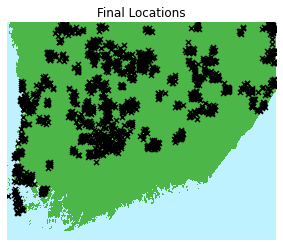

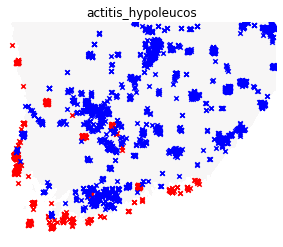

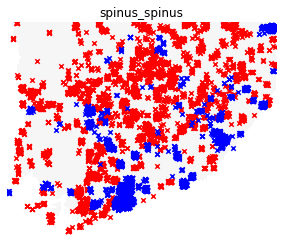

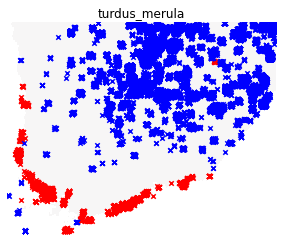

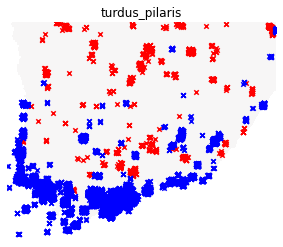

In [18]:
plt.figure(0)
plt.imshow(in_bounds, cmap=cmap_base, origin='upper')
plt.scatter(res["col"], res["row"], marker='x', s=25, color="black");
plt.axis('off')
plt.title("Final Locations");

for j in range(p):
    plt.figure(j+1)
    tmp = 0*a_prior[:,:,j]
    tmp[(a_prior[:,:,j] < 0.25)*(a_post[:,:,j] > 0.75)] = 1
    tmp[(a_prior[:,:,j] > 0.75)*(a_post[:,:,j] < 0.25)] = -1
    plt.imshow(tmp, cmap="RdBu_r")
    y_pos, x_pos = np.where(tmp > 0)
    plt.scatter(x_pos, y_pos, marker='x', s=20, color="red")
    y_pos, x_pos = np.where(tmp < 0)
    plt.scatter(x_pos, y_pos, marker='x', s=20, color="blue")
    plt.title(spnames[j])
    plt.axis('off')

# Randomize locations post-hoc for scientists to prevent bias from sampling all positive or all negative on the same day?